# 6 Hour Forecast using Dynamic Graph

In [1]:
%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pickle # to access dataframe faster than csv
import glob, re
import os
import csv
from pathlib import Path
import scipy as sp
import networkx
import torch_geometric
import torch
from torch_geometric.utils.convert import from_networkx
from scipy.sparse import coo_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# for tweaked_TAGConv 
import torch.nn as nn
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm # adjacency matrix normalization
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import zeros # initialize weights and biases for nn
from torch_geometric.typing import Adj, OptTensor, SparseTensor
from torch_geometric.utils import spmm # for sparse matrix multiplication

# for normalizing 
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [2]:
from utils import blocked_cross_validation_idx,get_windows_idx,get_train_batch_blocks

## Initialize
1. Aggregated (dataframe available at https://drive.google.com/drive/folders/1CwSLAJeCGUuHXRJOZ9YgkraHYaE8pGGH?usp=sharing)
2. Load aggregated
3. Load window csv with lclids corresponding to aggregated data

In [3]:
if False and torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

In [4]:
# load the data
file = open('uk-smart-meter-aggregated/df_agg.pkl','rb')
df_agg = pickle.load(file)
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2012-01-01 00:00:00 to 2013-12-31 23:00:00
Columns: 5558 entries, 2 to 5564
dtypes: float64(5558)
memory usage: 744.1 MB


In [5]:
file = open('uk-smart-meter-aggregated/windows_agg_ids.pkl','rb')
windows = pickle.load(file)
windows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5558 entries, 0 to 5557
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   LCLid        5558 non-null   int64          
 1   Enabled At   5558 non-null   datetime64[ns] 
 2   Disabled At  5558 non-null   datetime64[ns] 
 3   Duration     5558 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), timedelta64[ns](1)
memory usage: 217.1 KB


## Snapshot-based temporal graph
Idea: Build the adjacency matrix for all nodes using `create_adjacency_matrix`. Select a time-stamp for example [0]: '2012-01-01 00:00:00' or [1]: '2012-01-01 01:00:00' and so on. For this time-stamp what all nodes are active? Make an adjacency matrix for only these nodes for that particular time stamp using `get_snapshot_adjacency`. This function further returns the LCLids of active nodes (2,3,... 5564) and the indices of those active nodes (dataframe indices as in from range 0 to 5557).

1. Get the adjacency matrix for *all the nodes* at once to avoid computation

Number of unique start dates:  2154
Graph connected for k=50: True
sparsity:  0.9439180477754235


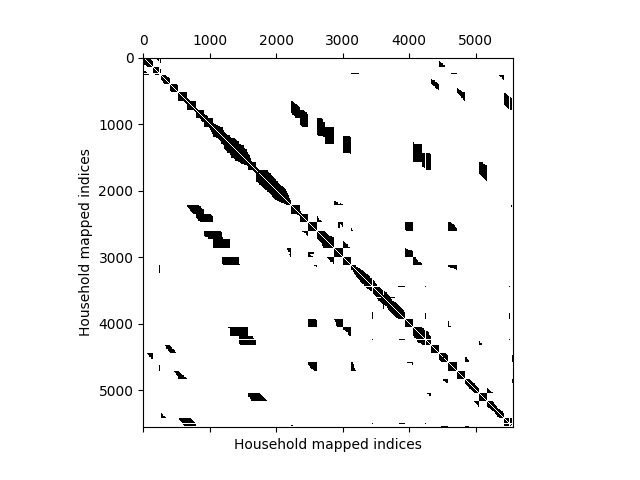

In [6]:
def create_adjacency_matrix(lclids, k):
    number_of_nodes = sum([len(l) for l in lclids])
    adjacency_matrix = np.zeros((number_of_nodes, number_of_nodes))
    # Create the graph by iterating over the list of lists of LCLids
    # and connecting all nodes in the list with each other
    # and with the k-nearest lists
    for i in range(len(lclids)): # range 2156
        for j in range(len(lclids)): # range 2156 
            if i == j: 
                for lclid in lclids[i]:
                    for lclid2 in lclids[j]:
                        adjacency_matrix[lclid, lclid2] = 1
            elif abs(i-j) <= k:
                for lclid in lclids[i]:
                    for lclid2 in lclids[j]:
                        adjacency_matrix[lclid, lclid2] = 1
    adjacency_matrix = adjacency_matrix - np.eye(number_of_nodes)
    return sp.sparse.bsr_array(adjacency_matrix)
    
# Sort rows by start date
windows_copy = windows.sort_values(by='Enabled At').copy()

# Get an ordered list of dates 'Enabled At'
enable_unique_dates = windows_copy['Enabled At'].unique()

# Get a list of lists of LCLids that have the same start date
nbor_lclids = [windows_copy[windows_copy['Enabled At'] == date].index.tolist() for date in enable_unique_dates]
print('Number of unique start dates: ', len(enable_unique_dates))
assert len(windows) == sum([len(l) for l in nbor_lclids])

# K-nearest neighbours
k = 50

adjacency_matrix = create_adjacency_matrix(nbor_lclids, k)
# Compute the sparsity of the adjacency matrix
sparsity = 1 - sp.sparse.bsr_matrix.count_nonzero(adjacency_matrix) / np.prod(adjacency_matrix.shape)
G = networkx.from_scipy_sparse_array(adjacency_matrix)
print(f'Graph connected for k={k}: {networkx.is_connected(G)}')
print('sparsity: ', sparsity)

plt.spy(sp.sparse.bsr_matrix.toarray(adjacency_matrix))
plt.xlabel("Household mapped indices"), plt.ylabel("Household mapped indices")
# save the adjacency matrix
np.save('Results/adjacency_matrix.npy', adjacency_matrix)
plt.show()

2. Make a function to get the sub-adjacency matrix for all nodes active at a given time instant

In [7]:
def get_snapshot_adjacency(timestampidx, full_adjacency_matrix, df_agg):
    """
    timestampidx: Time index; For example [0]: '2012-01-01 00:00:00'
    full_adjacency_matrix (np.array()): adjacency matrix for all the LCLids
    df_agg: aggregated dataframe with timeseries for all LCLids 
    
    Returns:
    indices_active_nodes: dataframe indices of active nodes
    active nodes: LCLids of active nodes 
    active_sparse_submat: adjacency matrix obtained for that particular timestamp (using timestampidx)
    """
    full_adjacency_matrix = full_adjacency_matrix.toarray()

    # get all the active nodes for that particular time-stamp
    active_nodes = df_agg.columns[df_agg.loc[df_agg.index[timestampidx], :].notna()]
    
    # indices of active nodes
    indices_active_nodes = windows[windows['LCLid'].isin(active_nodes.values)].index

    # active nodes sub-adjacency matrix
    active_adj_submat = full_adjacency_matrix[np.ix_(indices_active_nodes, indices_active_nodes)]

    if active_adj_submat.shape[0] != active_nodes.shape[0]:
        print(f'# active nodes = {active_nodes.shape}, while \
        Adjacency Matrix Shape = {active_adj_submat.shape}')
        raise RuntimeError()

    # create graph from the adjacency submatrix to check if it is connected
    active_sparse_submat = sp.sparse.bsr_array(active_adj_submat)

    ################ too slow ############################
    #G = networkx.from_scipy_sparse_array(active_sparse_submat)
    # check if the graph is fully connected
    # assert networkx.is_connected(G)

    # FOR FURTHER ANALYSIS
    #sparsity_submat = 1 - sp.sparse.bsr_matrix.count_nonzero(active_sparse_submat) \
    #/ np.prod(active_sparse_submat.shape)
    #print(f'Sparsity = {sparsity_submat}')
    
    
    # get edge indices from the adjacency submatrix COO Format
    # edge_index = torch.tensor(np.array(G.edges).T)
    #######################################################
    
    active_sparse_submat_coo = active_sparse_submat.tocoo()

    row = active_sparse_submat_coo.row
    col = active_sparse_submat_coo.col

    edge_index = torch.tensor(np.vstack((row, col)), dtype=torch.long)

    # node feature matrix 
    node_feat = torch.tensor(df_agg.loc[df_agg.index[timestampidx],active_nodes].values).view(-1,1)
    return indices_active_nodes, active_nodes, active_sparse_submat, node_feat, edge_index


# example usage:
indices, activenodes, active_sparse_submat, node_feat, edge_idx = get_snapshot_adjacency(0, adjacency_matrix, df_agg) # check exact date using df_agg.index[100]

### Align snapshots

Idea: Take snapshots for a window and extract the sub-adjacency matrices (only considering active nodes) and node features. And stack these sub-adjacency matrices as a dictionary (book).

In [8]:
# print(f'Snapshots taken at {df_agg.index[0]}, {df_agg.index[50]}, {df_agg.index[100]} to calculate the supra adjacency matrix')
def get_subadj_book(window_idx, adjacency_matrix, df_agg):
    """
    Input: 
        - window_idx:       window index (for eg., range(0,23) for first 24 hours)
        - adjacency_matrix: full adjacency matrix 
        - df_agg:           aggregated dataframe 
    Returns 
        - idx_book:       dict of indices (of dataframe) of all active nodes throughout the window for all time instances
        - actnod_book:    dict of LCLids of active nodes throughout the window for all time instances
        - subadj_book:    dict of subadjacency matrices throughout the window for all time instances (can be of different sizes)
        - all_nodes:      set of LCLids of all active unique nodes inside the window_idx
        - node_feat_book: dict of node feature matrix throughout the window for all instances
        - edge_idx_book:  dict of edge index throughout the window for all instances
    """
    node_feat_book = {}
    edge_idx_book = {}
    subadj_book = {}
    idx_book = {}
    actnod_book = {}
    all_nodes = set()

    def process_idx(i, idx):
        idx_i, actnod_i, subadj_i, node_feat_i, edge_idx_i = get_snapshot_adjacency(idx, adjacency_matrix, df_agg)
        return i, idx_i, actnod_i, subadj_i, node_feat_i, edge_idx_i

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_idx, i, idx) for i, idx in enumerate(window_idx)]
        #print(futures)
        for future in as_completed(futures):
            i, idx_i, actnod_i, subadj_i, node_feat_i, edge_idx_i = future.result()
            idx_book[i] = idx_i
            actnod_book[i] = actnod_i
            subadj_book[i] = subadj_i.toarray()
            node_feat_book[i] = node_feat_i
            edge_idx_book[i] = edge_idx_i
            all_nodes.update(actnod_i)
        
    return idx_book, actnod_book, subadj_book, all_nodes, node_feat_book, edge_idx_book

window_idx = np.arange(128) #100*np.array([0,1,2,3,4,5,6,7,8,9,10]) # training window
#idx_book, actnod_book, subadj_book, all_nodes, node_feat_book, edge_idx_book = get_subadj_book(window_idx, adjacency_matrix, df_agg)

Align the snapshots of different adjacency matrices to become size compatible. For example snapshot 1 has $R^{410\times410}$, snapshot 2 has $R^{450\times 450}$. This means that first snapshot has 410 active nodes and second snapshot has 450 active nodes. So, make a union set of all these nodes and "align" the shape of snapshot 2 adjacency matrix, node-features and edge_index to the shape of snapshot 2. So, snapshot 1 will also have adjacency matrix of size $R^{450\times 450}$ but with zeros at entries corresponding to the node that is not active in that snapshot 1.

In [9]:
def align_adjacency_matrix(active_nodes, subadj, all_nodes, node_index_map):
    """
    Input: 
        - active_nodes: list of active nodes 
        - subadj: sub-adjacency matrix for these active nodes
        - all_nodes: all the nodes for the entire window not just the instant where subadj and active_nodes are found
        - node_index_map: sorted all_nodes with {index: node...} 
        

    """
    if not isinstance(subadj, np.ndarray):
        subadj = subadj.toarray()

    # Create a mapping from active node to index
    active_node_indices = [node_index_map[node] for node in active_nodes]

    # Create aligned subadjacency matrix
    aligned_subadj = np.zeros((len(all_nodes), len(all_nodes)))
    
    # Use numpy advanced indexing to place the subadj matrix in the correct positions
    aligned_subadj[np.ix_(active_node_indices, active_node_indices)] = subadj

    return aligned_subadj


def get_aligned_adj_book(subadj_book, node_feat_book, actnod_book, all_nodes):
    
    # create node index mapping
    # for ex., index_mapping = {0,1,2,3,4,5} for sorted nodes {1,2,3,4,5,6}
    node_index_map = {node: i for i, node in enumerate(sorted(all_nodes))} # node: idx dictionary

    # total nodes 
    num_nodes = len(node_index_map)

    aligned_adj_book = {}
    aligned_node_feat_book = {}
    aligned_edge_index_book = {}

    for i, ((actkey, actnod), (subadjkey, subadj)) in enumerate(zip(actnod_book.items(), subadj_book.items())):
        #print(actkey, actnod), print(subadjkey, subadj)
        aligned_adj_book[i] = align_adjacency_matrix(actnod, subadj, all_nodes, node_index_map)
        # G = networkx.from_scipy_sparse_array(sp.sparse.bsr_array(aligned_adj_book[i]))
        # aligned_edge_index_book[i] = torch.tensor(np.array(G.edges).T)
        
        # Extract the indices of the non-zero elements (edges)
        row_indices, col_indices = np.nonzero(aligned_adj_book[i])

        # Combine the row and column indices to form the edge_index
        aligned_edge_index_book[i] = torch.tensor(np.vstack((row_indices, col_indices)))
        
        for j, key in enumerate(actnod.values):
            temp = np.zeros((len(all_nodes), 1))
            temp[node_index_map[key]] = node_feat_book[actkey][j]
        aligned_node_feat_book[i] = temp
    return aligned_adj_book, node_index_map, aligned_node_feat_book, aligned_edge_index_book



#### Use the same batch size as the one in preprocessing_batches.ipynb

In [10]:
def get_train_batch_blocks(start,end,batch_size=64,overlap=24):
    blocks=[]
    curr_start=start
    while curr_start<end:
        curr_end=min(curr_start+batch_size,end)
        blocks.append(np.arange(max(curr_start-overlap,0),curr_end))
        curr_start+=batch_size
    return blocks

In [11]:
df = pd.DataFrame({
    'DateTime': pd.date_range(start='2012-01-01 00:00:00', end='2013-12-31 23:00:00', freq='1h')
})
train_months=21
test_months=3
batch_size=128
overlap_months=0
train_test_blocks=blocked_cross_validation_idx(df,train_months,test_months,overlap_months)[0]

# Gets time indices for each window

train_batch_windows=get_train_batch_blocks(train_test_blocks[0],train_test_blocks[1],batch_size=batch_size)
test_batch_windows=get_train_batch_blocks(train_test_blocks[2],train_test_blocks[3],batch_size=batch_size)

In [12]:
if False:
    output_dir = 'subadj_books'
    os.makedirs(output_dir, exist_ok=True)
    for idx,window_idx in enumerate(train_batch_windows):
        #idx=idx+120
        idx_book, actnod_book, subadj_book, all_nodes, node_feat_book, edge_idx_book = get_subadj_book(window_idx, adjacency_matrix, df_agg)
        aligned_adj_book, node_index_map, aligned_node_feat_book, aligned_edge_index_book = get_aligned_adj_book(subadj_book, node_feat_book, actnod_book, all_nodes)
        
        # Save aligned_edge_index_book to pickle
        with open(os.path.join(output_dir, f'aligned_edge_index_book_{idx}.pkl'), 'wb') as f:
            pickle.dump(aligned_edge_index_book, f)
        
        # Save all_nodes to pickle
        with open(os.path.join(output_dir, f'all_nodes_{idx}.pkl'), 'wb') as f:
            pickle.dump(all_nodes, f)
        
        # Save aligned_node_feat_book to pickle
        with open(os.path.join(output_dir, f'aligned_node_feat_book_{idx}.pkl'), 'wb') as f:
            pickle.dump(aligned_node_feat_book, f)
        aligned_adj_book.clear()
        aligned_node_feat_book.clear()
        aligned_edge_index_book.clear()
        node_index_map.clear()
        idx_book.clear()
        actnod_book.clear()
        all_nodes.clear()
        node_feat_book.clear()
        edge_idx_book.clear()

### Graph-VAR

$$
\mathbf{x_t} = -\sum_{p=1}^{P} \sum_{k=0}^{K} h_{kp}\mathbf{S}_{t-p}^k \mathbf{x}_{t-p} 
$$

where P in our case will be 24. 

Dataset has 

In [13]:
class TemporalGraphDatasetLoaded:
    def __init__(self, adjacency_matrix, df_agg,window_idx=None,b=-1):
        self.graph_data = {}
        self.adjacency_matrix = adjacency_matrix
        self.df_agg = df_agg
        self.all_nodes_dict = {}
        self.batch_size=0
        if b>=0:
            self.add_batch_instance(window_idx,b)

    def add_batch_instance(self, window_idx, b):
        # extract the subadjacency matrix for all those time-stamps
        with open(f'subadj_books/all_nodes_{b}.pkl', 'rb') as f:
            all_nodes = pickle.load(f)
        with open(f'subadj_books/aligned_node_feat_book_{b}.pkl', 'rb') as f:
            aligned_node_feat_book = pickle.load(f)
        with open(f'subadj_books/aligned_edge_index_book_{b}.pkl', 'rb') as f:
            aligned_edge_index_book = pickle.load(f)
        if b not in self.all_nodes_dict:
            self.all_nodes_dict[b] = {}
        self.all_nodes_dict[b] = all_nodes
        
        # Initialize graph data for batch if not present
        if b not in self.graph_data:
            self.graph_data[b] = {}

        self.batch_size=len(aligned_node_feat_book)
        for i, idx in enumerate(window_idx):

            aligned_node_feat_book[i], aligned_edge_index_book[i], idx
            
            edge_index, edge_weight = gcn_norm(edge_index=aligned_edge_index_book[i].long(),
                                           edge_weight=None, 
                                           num_nodes=aligned_node_feat_book[i].shape[0],
                                           add_self_loops=False)
            
            # Create a Data object with node features, edge index, and edge weights
            data = Data(x=torch.tensor(aligned_node_feat_book[i]).float(), edge_index=edge_index.float(), edge_weight = edge_weight)

            self.graph_data[b][idx] = data

    def get_batch_instance(self, b):
        return self.graph_data.get(b, "Batch not found.")

    def get_batch_time_instance(self, b, idx):
        return self.graph_data.get(b, {}).get(idx, "Time instance not found.")

    def get_all_nodes(self, b):
        return self.all_nodes_dict[b]

    def get_batch_size(self):
        return self.batch_size

#for b, window_idx in enumerate(batch_windows):
    #dataset.add_batch_instance(window_idx, b)

In [15]:
class TemporalGCNLayer(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, K: int, P: int): # P from window_idx = np.arange(P)
        super(TemporalGCNLayer, self).__init__(aggr = 'add') # 'Add' aggregation
        self.K = K
        self.P = P
        # self.normalize = normalize
        # self.linear = nn.Linear(in_channels, out_channels)
        self.h = nn.Parameter(torch.Tensor(K+1, P)) # depends on the order of filter and P
        self.reset_parameters() # initialize parameters
        self.m = nn.ReLU()
        self.device='cpu'
        
    def reset_parameters(self):
        #nn.init.xavier_uniform_(self.linear.weight) # initialize the weight of the linear layer
        #nn.init.zeros_(self.linear.bias)
        nn.init.xavier_uniform_(self.h)

    def forward(self, data,idx) -> Tensor:
        dataset=data.get_batch_instance(idx)
        # keys of the given dataset as tensor 
        indices = torch.Tensor(list(dataset.keys())).int()
        batch_size = len(indices)# 128
        first_idx = indices[0].item() # since it is a tensor

        # Intialize output tensor # (428, 104)
        out = torch.zeros(dataset[first_idx].x.shape[0], batch_size - self.P).to(device)

        # Cache adjacency matrices and feature matrices 
        adj_matrices = []
        x_t_matrices = []

        for i in range(first_idx, first_idx + batch_size):
            edge_index = dataset[i].edge_index.long().to(device)
            edge_weight = dataset[i].edge_weight.to(device)
            num_nodes=dataset[i].x.shape[0]
            adj_sparse_tensor = SparseTensor(row = edge_index[0], col = edge_index[1], value = edge_weight,sparse_sizes=(num_nodes,num_nodes))
            adj_matrices.append(adj_sparse_tensor)
            x_t_matrices.append(dataset[i].x.to(device))

        # Compute the output using cached matrices
        for i_p in range(batch_size - self.P):
            out_kp = torch.zeros_like(x_t_matrices[0]).to(device)
            
            for p in range(self.P):
                idx = i_p + p
                x_t_minus_p = x_t_matrices[idx]
                adj_sparse_tensor = adj_matrices[idx]
                for k in range(self.K + 1):
                    h_kp = self.h[k, p]
                    out_kp += h_kp * self.propagate(adj_sparse_tensor, x = x_t_minus_p, k = k)

            out[:, i_p] = out_kp.view(-1)
            
        return self.m(out)
    
    def six_hour_forecast(self, data, idx,start_idx) -> Tensor:
        # keys of the given dataset as tensor
        dataset=data.get_batch_instance(idx)
        indices = torch.Tensor(list(dataset.keys())).int()
        batch_size = len(indices) 
        first_idx = indices[0].item() # since it is a tensor
        forecast_hours=6
        # Intialize output tensor # (428, 104)
        out = torch.zeros(dataset[start_idx].x.shape[0], 6).to(self.device)

        # Cache adjacency matrices and feature matrices
        adj_matrices = []
        x_t_matrices = []

        for i in range(start_idx, start_idx + P):
            edge_index = dataset[i].edge_index.long().to(self.device)
            edge_weight = dataset[i].edge_weight.to(self.device)
            adj_sparse_tensor = SparseTensor(row = edge_index[0], col = edge_index[1], value = edge_weight)
            adj_matrices.append(adj_sparse_tensor)
            x_t_matrices.append(dataset[i].x.to(self.device))

        # Compute the output using cached matrices
        for t in range(forecast_hours):
            out_kp = torch.zeros_like(x_t_matrices[0]).to(self.device)
            for p in range(self.P):
                idx=t+p
                x_t_minus_p = x_t_matrices[idx]
                adj_sparse_tensor = adj_matrices[idx]
                for k in range(self.K + 1):
                    h_kp = self.h[k, p]
                    out_kp += h_kp * self.propagate(adj_sparse_tensor, x = x_t_minus_p, k = k)
            out[:,t]=out_kp.view(-1)
            x_t_matrices.append(out_kp)
            # Assume adjacency matrix doesn't change
            adj_matrices.append(adj_matrices[-1])
            

        return self.m(out).clone().detach()

    def propagate(self, adj_sparse_tensor, x = None, k = 1):
        x_out = x
        for _ in range(k):
            x_out = adj_sparse_tensor.matmul(x_out)
        return x_out

class TemporalGCN(nn.Module):
    def __init__(self, in_channels, out_channels, K, P):
        super(TemporalGCN, self).__init__()
        self.gcn_layer = TemporalGCNLayer(in_channels, out_channels, K, P)

    def forward(self, dataset,idx):
        return self.gcn_layer(dataset,idx)
    
    def six_hour_forecast(self,dataset,idx,start_idx):
        return self.gcn_layer.six_hour_forecast(dataset,idx,start_idx)

# Initialize the model
in_channels = 1 # 1 feature
out_channels = 1 # 1 feature
K = 2 # order of polynomial filter
P = 24
model = TemporalGCN(in_channels, out_channels, K, P).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.02)
criterion = nn.MSELoss()

In [15]:
# count the number of parameters to verify 
# for K = 2, P = 3, no. of parameters = 9
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_parameters(model)
print(f'The model has {num_params} parameters')

The model has 72 parameters


In [16]:
def get_target(window_idx, all_nodes, P):
    target_timestamps = window_idx[P:]
    # get target values for all the nodes active for training 
    # target = torch.tensor(df_agg.loc[df_agg.index[target_timestamp],list(all_nodes)].values).view(-1,1).float().to(device)
    targets = torch.Tensor([])
    for tt in target_timestamps:
        if targets.numel() == 0:  # Check if targets is empty
            targets = torch.tensor(df_agg.loc[df_agg.index[tt], list(all_nodes)].values).view(-1, 1).float()
        else:
            new_tensor = torch.tensor(df_agg.loc[df_agg.index[tt], list(all_nodes)].values).view(-1, 1).float()
            targets = torch.cat((targets, new_tensor), dim=1)
    targets = torch.nan_to_num(targets)
    return targets

In [35]:
best_test_loss=np.inf
model = TemporalGCN(in_channels, out_channels, K, P).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()
last_epoch =0
best_test_loss=np.inf

### Train on subset of data for a reasonable training time

In [18]:
# Training Loop
num_epochs = 100
train_losses = []
test_losses=[]
patience=0
predict=0
last_train_batch=51
#last_epoch=0
if False:
    for epoch in tqdm(range(last_epoch,num_epochs)):
        batch_losses = []
        for idx,window_idx in enumerate(train_batch_windows[:last_train_batch]):
            dataset = TemporalGraphDatasetLoaded(adjacency_matrix, df_agg,window_idx,idx)
            model.train()
            optimizer.zero_grad()

            # Forward pass 
            predict = model(dataset,idx)
            target = get_target(window_idx, dataset.get_all_nodes(idx), P)
            
            loss = criterion(predict, target.to(device))
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            # train_losses.append(loss.item())
            # print(f'Batch loss: {loss.item():.4f}')
            batch_losses.append(loss.item())
            del dataset
            torch.cuda.empty_cache()
        # if (epoch+1) % 20 == 0:
        avg_train_loss=sum(batch_losses)/68
        train_losses.append(avg_train_loss)
        
        batch_losses = []
        for idx, window_idx in enumerate(train_batch_windows[last_train_batch:(last_train_batch+17)]):
            idx+=last_train_batch
            model.eval()
            optimizer.zero_grad()
            # Forward pass
            dataset = TemporalGraphDatasetLoaded(adjacency_matrix, df_agg,window_idx,idx)
            predict = model(dataset,idx)
            target = get_target(window_idx, dataset.get_all_nodes(idx), P)

            loss = criterion(predict, target.to(device))
            batch_losses.append(loss.item())
            del dataset
            torch.cuda.empty_cache()
        avg_test_loss=sum(batch_losses)/17
        test_losses.append(avg_test_loss)
        if avg_test_loss<best_test_loss and abs(avg_test_loss-best_test_loss)>5e-5:
            best_test_loss=avg_test_loss
            patience=0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'test_loss': avg_test_loss,
                'test_losses':test_losses,
                'train_losses':train_losses
            }, 'models/saved_dataset_best_model.pth')
            print(f'Best model at epoch {epoch+1} with test loss of {best_test_loss}')
        else:    
            patience+=1
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss:{avg_test_loss:.4f}')
        if patience==5:
            break
    
    
print("Training Finished!")

  1%|          | 1/100 [09:46<16:07:59, 586.67s/it]

Best model at epoch 1 with test loss of 0.609852086095249
Epoch [1/100], Train Loss: 0.3570, Test Loss:0.6099


  2%|▏         | 2/100 [19:33<15:58:40, 586.94s/it]

Best model at epoch 2 with test loss of 0.6094899142489714
Epoch [2/100], Train Loss: 0.3538, Test Loss:0.6095


  3%|▎         | 3/100 [29:20<15:48:50, 586.91s/it]

Best model at epoch 3 with test loss of 0.6091414479648366
Epoch [3/100], Train Loss: 0.3509, Test Loss:0.6091


  4%|▍         | 4/100 [39:10<15:40:52, 588.05s/it]

Best model at epoch 4 with test loss of 0.6088173231657814
Epoch [4/100], Train Loss: 0.3485, Test Loss:0.6088


  5%|▌         | 5/100 [48:55<15:29:24, 587.00s/it]

Best model at epoch 5 with test loss of 0.6085294537684497
Epoch [5/100], Train Loss: 0.3465, Test Loss:0.6085


  6%|▌         | 6/100 [58:44<15:20:37, 587.64s/it]

Best model at epoch 6 with test loss of 0.6082719354068532
Epoch [6/100], Train Loss: 0.3451, Test Loss:0.6083


  7%|▋         | 7/100 [1:08:29<15:09:41, 586.89s/it]

Best model at epoch 7 with test loss of 0.608054427539601
Epoch [7/100], Train Loss: 0.3439, Test Loss:0.6081


  8%|▊         | 8/100 [1:18:12<14:57:42, 585.46s/it]

Best model at epoch 8 with test loss of 0.6078658279250649
Epoch [8/100], Train Loss: 0.3432, Test Loss:0.6079


  9%|▉         | 9/100 [1:27:57<14:47:59, 585.49s/it]

Best model at epoch 9 with test loss of 0.607713545069975
Epoch [9/100], Train Loss: 0.3425, Test Loss:0.6077


 10%|█         | 10/100 [1:37:42<14:37:43, 585.15s/it]

Best model at epoch 10 with test loss of 0.6075849182465497
Epoch [10/100], Train Loss: 0.3422, Test Loss:0.6076


 11%|█         | 11/100 [1:47:26<14:27:27, 584.80s/it]

Best model at epoch 11 with test loss of 0.607481961741167
Epoch [11/100], Train Loss: 0.3418, Test Loss:0.6075


 12%|█▏        | 12/100 [1:57:10<14:17:18, 584.53s/it]

Best model at epoch 12 with test loss of 0.607401917962467
Epoch [12/100], Train Loss: 0.3417, Test Loss:0.6074


 13%|█▎        | 13/100 [2:06:54<14:07:22, 584.40s/it]

Best model at epoch 13 with test loss of 0.6073331745231852
Epoch [13/100], Train Loss: 0.3417, Test Loss:0.6073


 14%|█▍        | 14/100 [2:16:40<13:58:24, 584.93s/it]

Best model at epoch 14 with test loss of 0.6072762748774361
Epoch [14/100], Train Loss: 0.3414, Test Loss:0.6073


 15%|█▌        | 15/100 [2:26:27<13:49:36, 585.61s/it]

Epoch [15/100], Train Loss: 0.3413, Test Loss:0.6072


 16%|█▌        | 16/100 [2:36:13<13:39:50, 585.60s/it]

Best model at epoch 16 with test loss of 0.6071958769770229
Epoch [16/100], Train Loss: 0.3413, Test Loss:0.6072


 17%|█▋        | 17/100 [2:45:58<13:30:07, 585.63s/it]

Epoch [17/100], Train Loss: 0.3411, Test Loss:0.6072


 18%|█▊        | 18/100 [2:55:43<13:19:47, 585.21s/it]

Best model at epoch 18 with test loss of 0.6071421048220467
Epoch [18/100], Train Loss: 0.3411, Test Loss:0.6071


 19%|█▉        | 19/100 [3:05:27<13:09:54, 585.11s/it]

Epoch [19/100], Train Loss: 0.3409, Test Loss:0.6071


 20%|██        | 20/100 [3:15:13<13:00:09, 585.12s/it]

Epoch [20/100], Train Loss: 0.3409, Test Loss:0.6071


 21%|██        | 21/100 [3:25:01<12:51:52, 586.24s/it]

Best model at epoch 21 with test loss of 0.6070834994316101
Epoch [21/100], Train Loss: 0.3409, Test Loss:0.6071


 22%|██▏       | 22/100 [3:34:50<12:43:05, 586.99s/it]

Epoch [22/100], Train Loss: 0.3407, Test Loss:0.6071


 23%|██▎       | 23/100 [3:44:35<12:32:35, 586.43s/it]

Epoch [23/100], Train Loss: 0.3407, Test Loss:0.6071


 24%|██▍       | 24/100 [3:54:18<12:21:15, 585.21s/it]

Epoch [24/100], Train Loss: 0.3407, Test Loss:0.6070


 25%|██▌       | 25/100 [4:04:05<12:12:14, 585.80s/it]

Best model at epoch 25 with test loss of 0.6070310999365414
Epoch [25/100], Train Loss: 0.3405, Test Loss:0.6070


 26%|██▌       | 26/100 [4:13:51<12:02:45, 586.02s/it]

Epoch [26/100], Train Loss: 0.3405, Test Loss:0.6070


 27%|██▋       | 27/100 [4:23:39<11:53:34, 586.50s/it]

Epoch [27/100], Train Loss: 0.3405, Test Loss:0.6070


 28%|██▊       | 28/100 [4:33:25<11:43:37, 586.35s/it]

Epoch [28/100], Train Loss: 0.3404, Test Loss:0.6070


 29%|██▉       | 29/100 [4:43:12<11:34:13, 586.67s/it]

Epoch [29/100], Train Loss: 0.3403, Test Loss:0.6070


 29%|██▉       | 29/100 [4:52:59<11:57:19, 606.19s/it]

Epoch [30/100], Train Loss: 0.3403, Test Loss:0.6070
Training Finished!


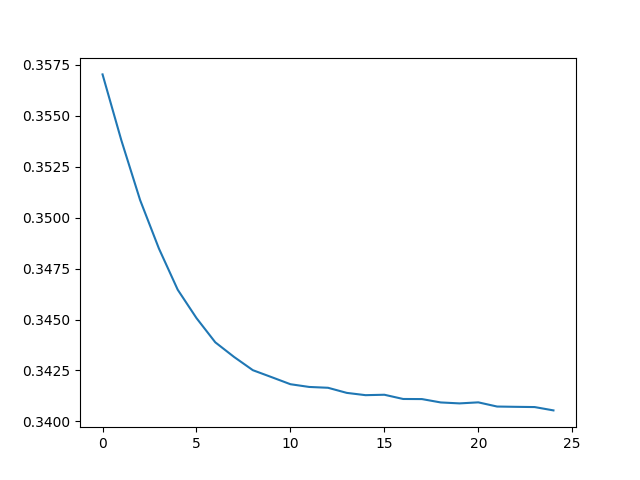

In [19]:
fig, ax = plt.subplots()
ax.plot(train_losses)

plt.show()

### Compare prediction and true values for a small window

#### Get window of 6 days in before and 2 days after last training index

In [16]:
from utils import TemporalGraphDataset

In [17]:
pivot_idx=train_batch_windows[50][-1]
input_start_idx=pivot_idx-24-6
window_start_idx=pivot_idx-24*6
end_idx=pivot_idx+2*24+1
print(window_start_idx,input_start_idx,pivot_idx,end_idx)

6383 6497 6527 6576


In [18]:
input_window_idx=np.arange(input_start_idx,end_idx)
window_idx=np.arange(window_start_idx,end_idx)
len(window_idx)

193

In [19]:
df.loc[6527]

DateTime   2012-09-28 23:00:00
Name: 6527, dtype: datetime64[ns]

In [20]:
input_window_idx

array([6497, 6498, 6499, 6500, 6501, 6502, 6503, 6504, 6505, 6506, 6507,
       6508, 6509, 6510, 6511, 6512, 6513, 6514, 6515, 6516, 6517, 6518,
       6519, 6520, 6521, 6522, 6523, 6524, 6525, 6526, 6527, 6528, 6529,
       6530, 6531, 6532, 6533, 6534, 6535, 6536, 6537, 6538, 6539, 6540,
       6541, 6542, 6543, 6544, 6545, 6546, 6547, 6548, 6549, 6550, 6551,
       6552, 6553, 6554, 6555, 6556, 6557, 6558, 6559, 6560, 6561, 6562,
       6563, 6564, 6565, 6566, 6567, 6568, 6569, 6570, 6571, 6572, 6573,
       6574, 6575], dtype=int64)

In [21]:
dataset=TemporalGraphDataset(adjacency_matrix,df_agg)
dataset.add_batch_instance(input_window_idx,0)
dataset.add_batch_instance(window_idx,1)

In [26]:
dataset.get_all_nodes(0)-dataset.get_all_nodes(1)

set()

In [ ]:
np.random(seed)

In [27]:
dataset.get_all_nodes(0)

{3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 13,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 18

In [115]:
checkpoint = torch.load('models/saved_dataset_best_model.pth')
model = TemporalGCN(in_channels, out_channels, K, P).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
# Load the state dictionary into the model
model.load_state_dict(checkpoint['model_state_dict'])
# Load the state dictionary into the optimizer
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Restore other information if needed
last_epoch = checkpoint['epoch']
avg_train_loss = checkpoint['train_loss']
avg_test_loss = checkpoint['test_loss']
train_losses=checkpoint['train_losses']
test_losses=checkpoint['test_losses']
best_test_loss=avg_test_loss

In [123]:
# 1h forecast
one_h_preds=model.forward(window_dataset,0).shape

In [121]:
model.six_hour_forecast(window_dataset,0,6547).shape

torch.Size([5001, 6])

In [122]:
six_h_preds=[]
for idx in window_idx[:-24]:
    op=model.six_hour_forecast(window_dataset,0,idx)[:,-1]
    six_h_preds.append(op)


In [107]:
op.shape

torch.Size([5001])

## Below part is not useful but kept for backup.

### Build the supra-adjacency matrix $S_\diamond$ from all the aligned subadjacency matrices "book" $\$_i$ 
Build a supra-adjacency matrix for $n$ time instances using spatio-temporal coupling. Note: we cannot use the kronecker product here since at all instances, the adjacnecy matrix `aligned_subadj1/2/3` is different. 

In [ ]:
def supra_adjacency_matrix(aligned_subadj_book):

    # convert the dict to stack 
    stacked_aligned_subadj = np.stack(list(aligned_book.values()), axis = -1)
    
    # time instances
    instances = stacked_aligned_subadj.shape[2]

    # size of aligned
    a_size = stacked_aligned_subadj.shape[0]

    # supra 
    S = np.zeros((a_size*instances, a_size*instances))

    # Place aligned at appropriate locations for spatio-temporal coupling
    # temporal + own-node spatial component
    for i in range(1,instances):
        S[i*a_size:(i+1)*a_size, (i-1)*a_size:i*a_size] = stacked_aligned_subadj[...,i-1] + np.eye(a_size) # last term is own-node spatial component
    # spatial coupling
    for i in range(instances):
        S[i*a_size:(i+1)*a_size, i*a_size:(i+1)*a_size] = stacked_aligned_subadj[...,i]
    
    return S

supra_adj_mat = supra_adjacency_matrix(aligned_book)

In [ ]:
fig, ax = plt.subplots()
plt.spy(supra_adj_mat)
plt.show()

### Imputation on Supra-adjacency matrix/Product Graph

In [ ]:
len(all_nodes)*len(window_idx)

In [ ]:
# fill the y_diamond using data
y_diamond = np.zeros([len(all_nodes)*len(actnod_book), 1])

# the index with corresponding lclid will get the data

# 6th LCLid 
y_diamond[0] = df_agg.loc[df_agg.index[window_idx[0]],list(all_nodes)[0]] 
# 16th LCLid
y_diamond[1] = df_agg.loc[df_agg.index[window_idx[1]], list(all_nodes)[1]]
